# Dynamics of a small solvated peptide chain (5-mer)
(Lammps example)

Created by Georgii Vandyshev (B02-004)

# 0. Import lib

In [1]:
from ase.io import read
from ase.visualize import view
import numpy as np
import nglview
import plotly.graph_objects as go
import pickle
import multiprocessing as mp

## 1. Default system

In [4]:
data = read("../input/data.peptide", format='lammps-data')
view(data, viewer="ngl")

# Visualization dump

In [2]:
%%time
data = dict()
T = range(270, 320, 10)
# for t in range(270, 320, 10):
#     data[t] =  read(f'../data/dump/dump.peptide_{t}', index=':')
    
def read_dump(t):
    data = read(f'../data/dump/dump.peptide_{t}', index=':')
    return {'dump': data, 'T': t}

with mp.Pool(8) as p:
    data = p.map(read_dump, T)

with open('../pickle/dumps.pickle', "wb") as f:
    pickle.dump(data, f)

CPU times: user 315 ms, sys: 77.8 ms, total: 393 ms
Wall time: 8.05 s


In [3]:
%%time
data = dict()
T = range(270, 320, 10)
for t in range(270, 320, 10):
    data[t] =  read(f'../data/dump/dump.peptide_{t}', index=':')

with open('../pickle/dumps.pickle', "wb") as f:
    pickle.dump(data, f)

CPU times: user 6.32 s, sys: 34.2 ms, total: 6.35 s
Wall time: 6.4 s


In [10]:
T = 270 # notification in telegram

data = read(f"../data/dump/dump.peptide_{T}", index=':')
view(data, viewer="ngl")

In [11]:
nglview.show_asetraj(data, gui=True)

NGLWidget(max_frame=1000)

# MSD

$MSD(t) = \langle |\mathbf{x}(t)-\mathbf{x_0}|^2\rangle=\frac{1}{N}\sum_{i=1}^N |\mathbf{x^{(i)}}(t) - \mathbf{x^{(i)}}(0)|^2$

In [16]:
msd = []
Temp = range(270, 320, 10)

for t in Temp:
    data = np.genfromtxt(f'../data/msd/temp_{t}.msd', skip_header=2)
    msd.append(data)
    
with open('../pickle/msd.pickle', "wb") as f:
    pickle.dump(msd, f)

In [26]:
msd = []
Temp = range(270, 320, 10)

def read_msd(t):
    data = np.genfromtxt(f'../data/msd/temp_{t}.msd', skip_header=2)
    return {'msd': data, 'T': t}

with mp.Pool(4) as p:
    msd = p.map(read_msd, Temp)
    
print(msd)

with open('../pickle/msd.pickle', "wb") as f:
    pickle.dump(msd, f)

[{'msd': array([[0.00000e+00, 6.49178e-12],
       [1.00000e+00, 1.00679e-03],
       [2.00000e+00, 4.03604e-03],
       ...,
       [9.99800e+03, 5.04097e+00],
       [9.99900e+03, 5.04498e+00],
       [1.00000e+04, 5.04750e+00]]), 'T': 270}, {'msd': array([[0.00000e+00, 6.49178e-12],
       [1.00000e+00, 1.00679e-03],
       [2.00000e+00, 4.03611e-03],
       ...,
       [9.99800e+03, 9.60440e+00],
       [9.99900e+03, 9.60741e+00],
       [1.00000e+04, 9.60954e+00]]), 'T': 280}, {'msd': array([[0.00000e+00, 6.49178e-12],
       [1.00000e+00, 1.00680e-03],
       [2.00000e+00, 4.03618e-03],
       ...,
       [9.99800e+03, 9.56952e+00],
       [9.99900e+03, 9.56795e+00],
       [1.00000e+04, 9.57503e+00]]), 'T': 290}, {'msd': array([[0.00000e+00, 6.49178e-12],
       [1.00000e+00, 1.00680e-03],
       [2.00000e+00, 4.03624e-03],
       ...,
       [9.99800e+03, 1.00410e+01],
       [9.99900e+03, 1.00422e+01],
       [1.00000e+04, 1.00396e+01]]), 'T': 300}, {'msd': array([[0.00000e+00

In [28]:
with open('../pickle/msd.pickle', "rb") as f:
    msd = pickle.load(f)

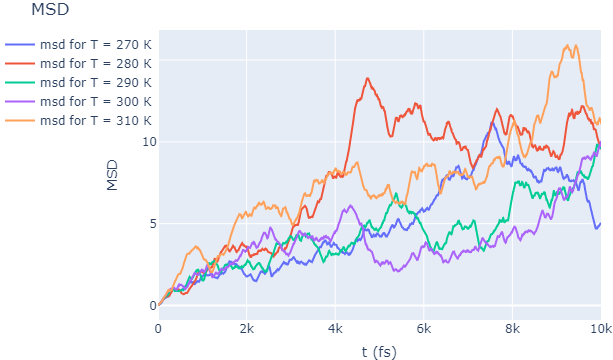

In [31]:
fig = go.Figure()

msd = sorted(msd, key=lambda x: x['T'])

for i in range(len(Temp)):
    fig.add_trace(go.Scatter(x=msd[i]['msd'][:, 0], y=msd[i]['msd'][:, 1],  name=f'msd for T = {Temp[i]} К'))
fig.update_layout(legend_orientation="v",
                  legend=dict(x=0, xanchor="right"),
                  title="MSD",
                  yaxis_title="MSD",
                  xaxis_title="t (fs)",
                  margin=dict(l=0, r=0, t=30, b=0))
fig.show()

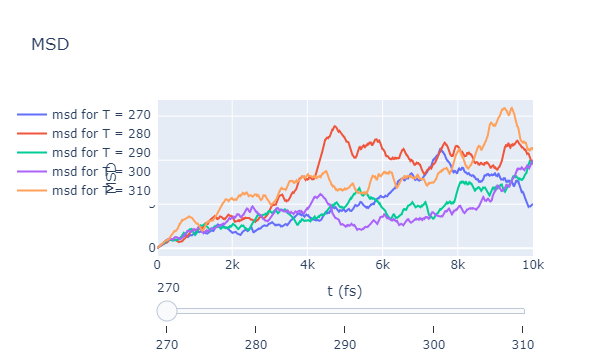

In [33]:
num_steps = len(Temp)
trace_list = []

for i in range(len(Temp)):
    trace_list.append(go.Scatter(x=msd[i]['msd'][:, 0], y=msd[i]['msd'][:, 1],  name=f'msd for T = {Temp[i]}'))

fig = go.Figure(data=trace_list)

steps = []
for i in range(num_steps):
    step = dict(
        label = Temp[i],
        method = 'restyle',  
        args = ['visible', [False] * len(fig.data)],
    )
    # Enable trace we want to see
    step['args'][1][i] = True
    
    # Add step to step list
    steps.append(step)

sliders = [dict(
    # urrentvalue = {"prefix": 'msd for T = ', "font": {"size": 20}},
    # len = 0.9,
    # x = 0.1,
    # pad = {"b": 10, "t": 50},
    steps = steps,
)]

fig.layout.sliders = sliders

fig.update_layout(legend_orientation="v",
                  legend=dict(x=0, xanchor="right"),
                  title="MSD",
                  yaxis_title="MSD",
                  xaxis_title="t (fs)")

fig.show()